## IMPORTS

In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.functional as F


from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

import numpy as np
# Set seed for PyTorch
torch.manual_seed(42)

# Check if CUDA is available
cuda_available = torch.cuda.is_available()

print(f"CUDA Available: {cuda_available}")

CUDA Available: True


## DATALOADERS & PREPROCESSING

In [2]:
class CustomDataset(Dataset):
    def __init__(self, folder_path, transforms=None):
        self.folder_path = folder_path
        self.class_folders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]
        
        # Initialize LabelEncoder
        self.label_encoder = LabelEncoder()
        
        # Fit and transform class labels to numerical labels
        self.labels = self.label_encoder.fit_transform(self.class_folders)
        self.transform = transforms
        self.data = []
        
        for class_folder in self.class_folders:
            class_path = os.path.join(folder_path, class_folder)
            file_list = [f for f in os.listdir(class_path) if f.endswith('.npy')]

            for file_name in file_list:
                file_path = os.path.join(class_path, file_name)
                data_point = np.load(file_path)
                self.data.append((data_point, class_folder))



    def __len__(self):
            return len(self.data)
    
    def __getitem__(self, idx):
        data_point, class_name = self.data[idx]
        label = self.label_encoder.transform([class_name])[0]
        
        data_point = (data_point - np.mean(data_point, axis=(1,2)))/(np.std(data_point, axis=(1,2)))
        
        # Convert NumPy array to PyTorch tensor
        data_point = torch.from_numpy(data_point).float()

        if self.transform:
            data_point = self.transform(data_point)

        
        return data_point, label




In [3]:
size = 224

augmentation = transforms.Compose([
    transforms.Resize(size),
])

folder_path = '/kaggle/input/ml4sci-deeplense/dataset/train/'
custom_dataset = CustomDataset(folder_path, transforms=augmentation)


# Define the size of the training and testing sets[90:10]
train_size = int(0.9 * len(custom_dataset))
test_size = len(custom_dataset) - train_size

# Split the dataset into training and testing sets
train_dataset, test_dataset = random_split(custom_dataset, [train_size, test_size])

batch_size = 128

# train and test dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  #no shuffle

# validation dataloader
folder_path_val = '/kaggle/input/ml4sci-deeplense/dataset/val/'
custom_dataset_val = CustomDataset(folder_path, transforms=augmentation)
val_dataloader = DataLoader(custom_dataset_val, batch_size=batch_size, shuffle=True)

## BUILDING BLOCKS FOR CUSTOM ResNet

In [4]:


# Define building blocks
class ConvBN(nn.Module):
    '''
    Combines Convolution and BatchNorm
    '''
    def __init__(self, in_ch, out_ch, k, s, p, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, k, s, p)
        self.BN = nn.BatchNorm2d(out_ch)

    def forward(self, x):
        return self.BN(self.conv(x))

    

class ResBlock(nn.Module):
    '''
    Building block for a ResNet. 
    
    Two modes:
    Plain - if concat = False
    Skip Connect - if Concat = true
    '''
    def __init__(self, in_ch, out_ch, k, s, p, DP, concat=False, **kwargs):
        super().__init__()
        self.concat = concat
        self.shortcut = nn.Conv2d(in_ch, out_ch, kernel_size= 1,stride= 2, padding= 0)  # Renamed from "self.pass"
        self.relu = nn.ReLU(inplace=True)

        if self.concat:
            self.layer = nn.Sequential(
                ConvBN(in_ch, out_ch, k, s, p),
                nn.ReLU(inplace=True),
                ConvBN(out_ch, out_ch, k, s//2, p),
                nn.Dropout(DP)
            )
        else:
            self.layer = nn.Sequential(
                ConvBN(in_ch, out_ch, k, s, p),
                nn.ReLU(inplace=True),
                ConvBN(out_ch, out_ch, k, s, p),
                nn.Dropout(DP)
            )
            
    def forward(self, x):
        if self.concat:
            output = self.relu(self.shortcut(x) + self.layer(x))
        else: 
            output = self.relu(x + self.layer(x))
        return output
    

class SELayer(nn.Module):
    '''
    Squeeze Excite Block for better learning.
    Ref: https://arxiv.org/abs/1709.01507
    '''
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class SE_ResBlock(ResBlock):
    '''
    Modified ResBlock. Output from layer1 is passed
    through a SE unit.
    '''
    def __init__(self, in_ch, out_ch, k, s, p, DP, concat=False, downsample=None, reduction=16):
        super().__init__(in_ch, out_ch, k, s, p, DP, concat)
        self.se = SELayer(out_ch, reduction)
        self.downsample = downsample
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x  
        if self.downsample is not None:
            residual = self.downsample(x)

        out = self.se(self.layer(x))
        out = self.relu(residual + out)
        return out

## MODEL

Custom Implementation based on ResNet 18. Squeeze Excite Units added in betwwen. Observed improvements over base ResNet 18.

In [5]:
class CustomResNet(nn.Module):
    def __init__(self, n_classes, dropout = 0.5):
        super().__init__()

        self.layer_1 = nn.Sequential(
            ConvBN(1, 64, 7, 2, 3),
            nn.ReLU(),
            nn.MaxPool2d(3, 2, 1)
        )
            
        self.layer_2 = nn.Sequential(
            ResBlock(64, 64, 3, 1, 1, DP = dropout),
            ResBlock(64, 64, 3, 1, 1, DP = dropout),
            ResBlock(64, 128, 3, 2, 1, DP = dropout, concat = True),
            ResBlock(128, 128, 3, 1, 1, DP = dropout),
            SE_ResBlock(128, 128, 3, 1, 1, DP = dropout),
            ResBlock(128, 256, 3, 2, 1, DP = dropout, concat= True),
            ResBlock(256, 256, 3, 1,1, DP = dropout),
            SE_ResBlock(256, 256, 3, 1, 1, DP = dropout),
            ResBlock(256, 512, 3, 2, 1, DP = dropout, concat= True),
            ResBlock(512, 512, 3, 1, 1, DP = dropout),
            nn.AvgPool2d(7, 1)
        )



        self.class_head = nn.Sequential(
            nn.Linear(in_features = 1*1*512, out_features = 1000),
            nn.ReLU(),
            nn.Linear(in_features = 1000, out_features = n_classes)
                       
        )

    def forward(self, x):
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.class_head(x.reshape(x.shape[0], -1))
        # x = F.softmax(x, dim=1)

        return x
        


## TRAINING

In [6]:
!nvidia-smi
!nvcc --version
cuda_available = torch.cuda.is_available()

print(f"CUDA Available: {cuda_available}")

Sun Mar 16 08:39:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P0             26W /  250W |       3MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [14]:
## Model 

model = CustomResNet(n_classes = 3)

total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")


Total number of parameters: 13611939


In [8]:
!mkdir save_weights

In [15]:
#rerun model outputs un normalized
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
num_epochs = 400
best_accuracy = 0.0

test_loss_list = []
test_acc_list = []
for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_loss = 0.0
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    
    # Validation phase
    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for test_inputs, test_labels in test_dataloader:
            test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
            test_outputs = model(test_inputs)
            _, predicted = torch.max(test_outputs, 1)
            total_samples += test_labels.size(0)
            total_correct += (predicted == test_labels).sum().item()

    # Calculate accuracy
    accuracy = total_correct / total_samples

    if accuracy >= best_accuracy:
        best_accuracy = accuracy
        print(f"saving for epoch:{epoch} @ test accuracy {best_accuracy}") #typo should be 'epoch+1' instead of 'epoch'
        torch.save(model.state_dict(), f'/kaggle/working/save_weights/customNet_rerun.pth')
    
    # Print training and validation statistics
    print(f"Epoch {epoch + 1}/{num_epochs}, Test Loss: {avg_loss}, Accuracy on Test set: {accuracy * 100:.2f}%")
    test_loss_list.append((epoch, avg_loss))
    test_acc_list.append((epoch, accuracy))

saving for epoch:0 @ test accuracy 0.31033333333333335
Epoch 1/400, Test Loss: 1.10370094516266, Accuracy on Test set: 31.03%
saving for epoch:1 @ test accuracy 0.3363333333333333
Epoch 2/400, Test Loss: 1.101832611865907, Accuracy on Test set: 33.63%
saving for epoch:2 @ test accuracy 0.3363333333333333
Epoch 3/400, Test Loss: 1.1010184587460559, Accuracy on Test set: 33.63%
saving for epoch:3 @ test accuracy 0.3363333333333333
Epoch 4/400, Test Loss: 1.0999278355548732, Accuracy on Test set: 33.63%
saving for epoch:4 @ test accuracy 0.3363333333333333
Epoch 5/400, Test Loss: 1.0961060597433299, Accuracy on Test set: 33.63%
saving for epoch:5 @ test accuracy 0.3363333333333333
Epoch 6/400, Test Loss: 1.0924559696025757, Accuracy on Test set: 33.63%
saving for epoch:6 @ test accuracy 0.352
Epoch 7/400, Test Loss: 1.0763768867293806, Accuracy on Test set: 35.20%
saving for epoch:7 @ test accuracy 0.4716666666666667
Epoch 8/400, Test Loss: 0.9800410493855228, Accuracy on Test set: 47.17%

KeyboardInterrupt: 

Training prematurely stopped at 200 epochs as the loss almost stabilised. The best test accuracy occured around 90th epoch 94%

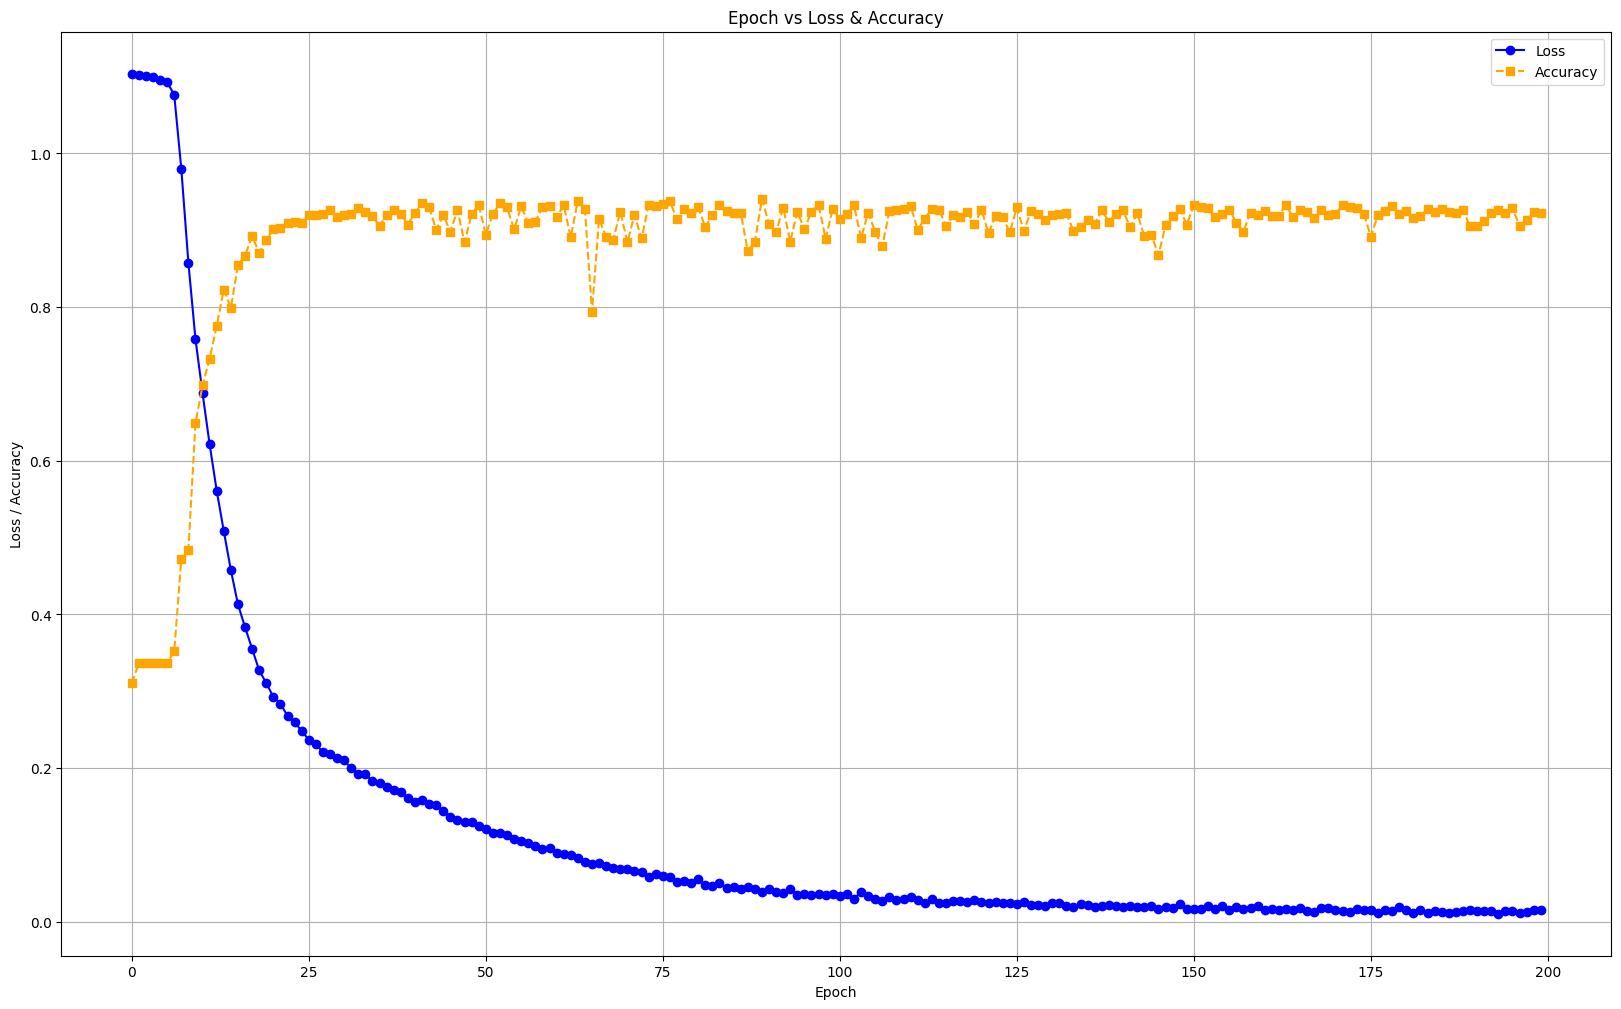

In [28]:
import matplotlib.pyplot as plt


# Unzip the data into separate lists
x1, y1 = zip(*test_loss_list)
x2, y2 = zip(*test_acc_list)

plt.figure(figsize=(20, 12))
plt.plot(x1, y1, marker='o', linestyle='-', color='b', label="Loss")
plt.plot(x2, y2, marker='s', linestyle='--', color='orange', label="Accuracy")

# Labels and title
plt.xlabel("Epoch")
plt.ylabel("Loss / Accuracy")
plt.title("Epoch vs Loss & Accuracy")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


## VALIDATION & METRICS (RERUN)

In [16]:
#Epoch - 246, test accuracy - 93.67%
checkpoint = "/kaggle/working/save_weights/customNet_rerun.pth"
model = CustomResNet(n_classes=3).to(device)
model.load_state_dict(torch.load(checkpoint))

<ipython-input-16-d5b574d5461f>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint))


<All keys matched successfully>

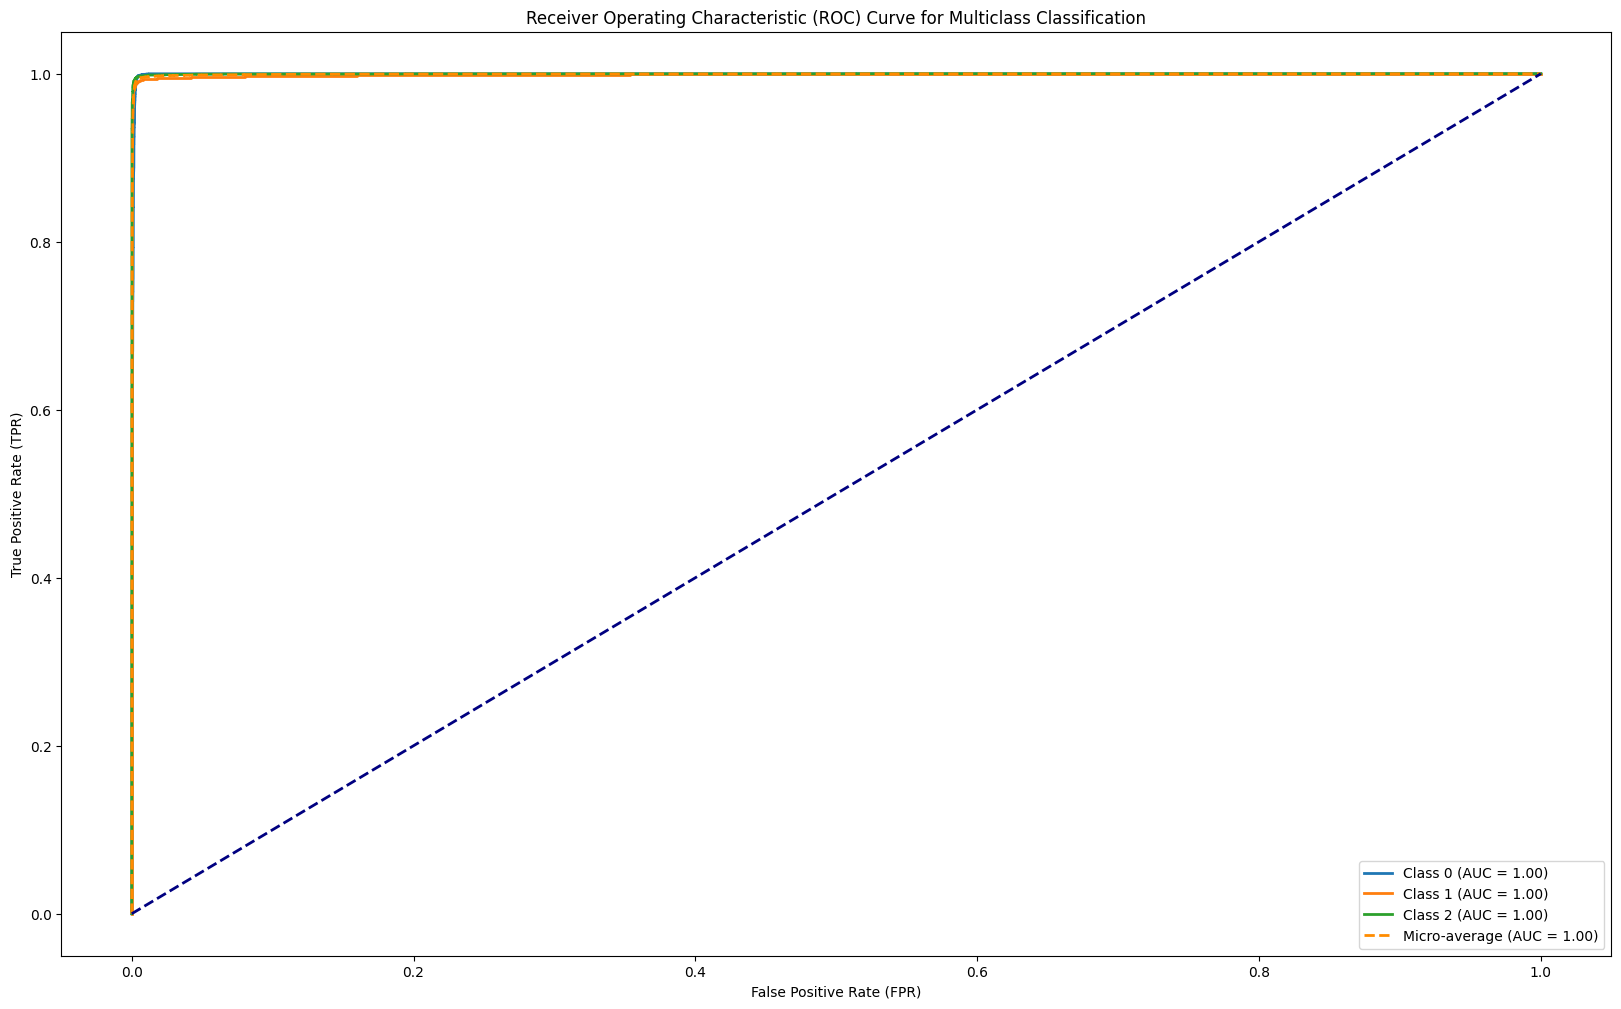

In [17]:
import matplotlib.pyplot as plt
model.eval()
num_classes = 3
all_labels = []
all_scores = []

with torch.no_grad():
    for val_inputs, val_labels in val_dataloader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_outputs = model(val_inputs)
        
        # Assuming the model outputs raw logits, apply softmax to get probabilities
        probabilities = torch.nn.functional.softmax(val_outputs, dim=1)
        
        all_labels.extend(val_labels.cpu().numpy())
        all_scores.extend(probabilities.cpu().numpy())

# Binarize the labels
y_true = label_binarize(all_labels, classes=list(range(num_classes)))

# Ensure y_true and all_scores are numpy arrays
y_true = np.array(y_true)
all_scores = np.array(all_scores)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], all_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), all_scores.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot the ROC curves
plt.figure(figsize=(20, 12))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot(fpr["micro"], tpr["micro"], color='darkorange', linestyle='--', lw=2, label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()


In [18]:
from sklearn.metrics import accuracy_score, classification_report


accuracy = accuracy_score(all_labels, np.argmax(all_scores, axis=1))
print(f"Accuracy: {accuracy:.5f}")

print(classification_report(all_labels, np.argmax(all_scores, axis=1), digits=4))



Accuracy: 0.99293
              precision    recall  f1-score   support

           0     0.9916    0.9967    0.9942     10000
           1     0.9898    0.9918    0.9908     10000
           2     0.9974    0.9903    0.9938     10000

    accuracy                         0.9929     30000
   macro avg     0.9929    0.9929    0.9929     30000
weighted avg     0.9929    0.9929    0.9929     30000



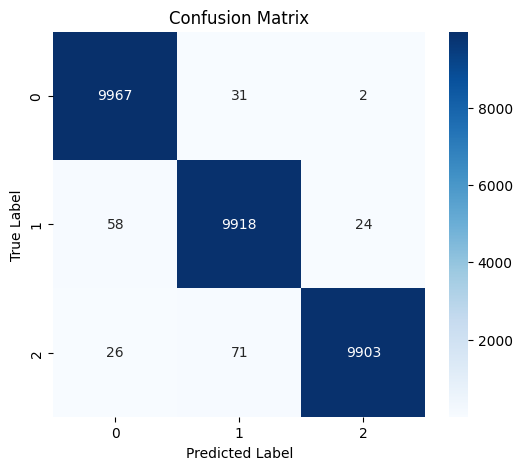

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(all_labels, np.argmax(all_scores, axis=1))
# print("Confusion Matrix:\n", conf_matrix)
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [20]:
folder_path = '/kaggle/input/ml4sci-deeplense/dataset/train/'
class_folders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]
label_encoder = LabelEncoder()
encoded_labels =  label_encoder.fit_transform(class_folders)


print("Class mapping:", dict(zip(class_folders, encoded_labels)))

Class mapping: {'no': 0, 'vort': 2, 'sphere': 1}


In [21]:
label_encoder.classes_

array(['no', 'sphere', 'vort'], dtype='<U6')

In [22]:
label = 1
print(f"Class for label {label}: {label_encoder.classes_[label]}")

Class for label 1: sphere
